In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
orders = pd.read_csv('orders.csv', parse_dates = ['order_date'])
orders.head()

,customer_id,order_date,revenue
0,Mr. Brion Stark Sr.,2004-12-20,32
1,Ethyl Botsford,2005-05-02,36
2,Hosteen Jacobi,2004-03-06,116
3,Mr. Edw Frami,2006-03-15,99
4,Josef Lemke,2006-08-14,76


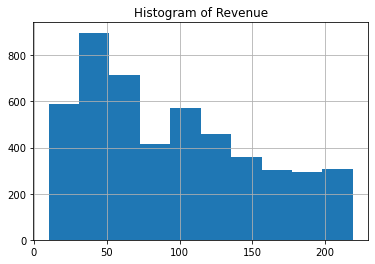

In [3]:
orders['revenue'].hist()
plt.title('Histogram of Revenue')
plt.show()

In [4]:
max_date = orders['order_date'].max()
agg_dict = {'order_date': lambda date: (max_date - date.max()).days,
            'customer_id': lambda num: len(num), 
            'revenue': lambda price: price.sum()}
rfm = orders.groupby('customer_id').agg(agg_dict) 
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.reset_index(inplace = True) 
rfm.head()

,customer_id,Recency,Frequency,Monetary
0,Abbey O'Reilly DVM,204,6,472
1,Add Senger,139,3,340
2,Aden Lesch Sr.,193,4,405
3,Admiral Senger,131,5,448
4,Agness O'Keefe,89,9,843


In [101]:
class RFMAnalysis:
    """
    An instance of this class can be used to perform RFM analysis, with different output types, 
    such as tables and plots.
    
    Attributes
    ----------
    data_path : str
        path to the dataframe
    customer : str
        column name for `customer` data
    revenue : str
        column name for `revenue` data
    date : str
        column name for `date` data
        
    Methods
    -------
    problemsolver(self)
    
    best_customers(self, n, n_quantiles = 4)
        
    worst_customers(self, n, n_quantiles = 4)
    
    table(self, n_quantiles = 4)
    
    table_grouped(self, n_quantiles = 4)
    
    plot_revenue(self)
    
    plot_segments(self, n_quantiles = 4)
    
    plot_traits(self, n_quantiles = 4)
    
    plot_segments_lines(self, n_quantiles = 4)
    """
    
    def __init__(self, data_path, customer, date, revenue):
        """
        Initializes the object.
        
        Parameters
        ----------
        data_path : str
            Path to the CSV file
        customer : str
            name of the event column 
        date : str
            name of the time column 
        revenue : str
            name of the group_by column 
        """
        
        try:
            self.data = pd.read_csv(data_path, parse_dates = [date])
        except FileNotFoundError:
            print("Error | Could not find the CSV file. Please, check that the requested file exists and is located in the working directory")
            return
        except ValueError:
            print("Error | Could not locate `date` column to parse dates")
            return 
        
        self.customer = customer
        self.date = date
        self.revenue = revenue
        
        if customer not in self.data:
            print("Error | Could not locate `customer` column. Please, check input.")
            
        if date not in self.data:
            print("Error | Could not locate `date` column. Please, check input.")
        
        if revenue not in self.data:
            print("Error | Could not locate `revenue` column. Please, check input.")
            
    def problemsolver(self):
        """
        Plots all available charts
        """
        self.plot_revenue()
        self.plot_segments()
        self.plot_traits()
        self.plot_segments_lines()
        
        best_3 = list(self.best_customers(3)[self.customer])
        worst_3 = list(self.worst_customers(3)[self.customer])
        print("Best:", ", ".join(best_3))
        print("Worst:", ", ".join(worst_3))
    
    def best_customers(self, n, n_quantiles = 4):
        """
        Outputs the best `n` customers. 
        
        Parameters
        ----------
        n : int
            Number of the best customers to return.
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        best = rfm.head(n)
            
        return best[[self.customer, "RFM_Score"]]
    
    def worst_customers(self, n, n_quantiles = 4):
        """
        Outputs the worst `n` customers. 
        
        Parameters
        ----------
        n : int
            Number of the worst customers to return.
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        best = rfm.tail(n)
            
        return best[[self.customer, "RFM_Score"]]
        
    def table(self, n_quantiles = 4):
        """
        Returns an aggregate table with Recency, Frequency and Monetary columns. In addition, 
        it outputs scores in the same table for each customer.
        
        Parameters
        ----------
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        max_date = self.data[self.date].max()
        agg_dict = {'order_date': lambda date: (max_date - date.max()).days,
                    'customer_id': lambda num: len(num), 
                    'revenue': lambda price: price.sum()}
        rfm = self.data.groupby(self.customer).agg(agg_dict) 
        rfm.columns = ['Recency', 'Frequency', 'Monetary']
        rfm.reset_index(inplace = True) 
        
        quantiles = [str(q) for q in range(1, n_quantiles + 1)]
        
        try:
            rfm['R'] = pd.qcut(rfm['Recency'], n_quantiles, quantiles)
            rfm['F'] = pd.qcut(rfm['Frequency'], n_quantiles, quantiles[::-1])
            rfm['M'] = pd.qcut(rfm['Monetary'], n_quantiles, quantiles[::-1])
        except ValueError:
            print("Error | too many quantiles provided. Try a smaller value.")
            return None
        
        rfm['RFM_Score'] = rfm.R.astype(int) + rfm.F.astype(int) + rfm.M.astype(int)
        rfm['RFM_Segment'] = rfm.R.astype(str) + rfm.F.astype(str) + rfm.M.astype(str)
        
        rfm = rfm.sort_values('RFM_Segment', ascending = False)
        
        rfm['Segment_Name'] = rfm.apply(self.__naming, axis=1)
        
        return rfm
    
    def table_grouped(self, n_quantiles = 4):
        """
        Returns an a grouped table with Recency, Frequency and Monetary columns with mean
        function applied to each.
        
        Parameters
        ----------
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        agg_dict = {'Recency': 'mean',
                    'Frequency': 'mean',
                    'Monetary': ['mean', 'count']
                   }

        grouped_by = rfm.groupby('Segment_Name').agg(agg_dict).round(1)
        grouped_by.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
        return grouped_by
    
    def plot_revenue(self):
        """
        Plot the revenue.
        """
        
        self.data[self.revenue].hist()
        plt.title('Histogram of Revenue')
        plt.show()
        
    def plot_segments(self, n_quantiles = 4):
        """
        Plot segments.
        
        Parameters
        ----------
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        rfm_grouped = self.table_grouped(n_quantiles)
        
        if rfm is None:
            return
        
        fig = plt.gcf()
        ax = fig.add_subplot()
        
        squarify.plot(sizes = rfm_grouped['Count'], label = RFMAnalysis.__default_score_codes, alpha = .6 )
        plt.title("RFM Segments", fontsize = 18, fontweight = "bold") 
        plt.axis('off')
        plt.show()
    
    def plot_traits(self, n_quantiles = 4):
        """
        Plot density charts for Recency, Frequency, Monetary.
        
        Parameters
        ----------
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        fig, ax = plt.subplots(nrows = 3, ncols = 1, figsize = (10,10))
        sns.distplot(rfm['Recency'], ax = ax[0])
        sns.distplot(rfm['Frequency'], ax = ax[1]) 
        sns.distplot(rfm['Monetary'], ax = ax[2])
        plt.show()
            
    def plot_segments_lines(self, n_quantiles = 4):
        """
        Plot lines for each segment. 
        
        Parameters
        ----------
        n_quantiles: int
            Number of quantiles to use during analysis.
        """
        
        rfm = self.table(n_quantiles)
        
        if rfm is None:
            return
        
        rfm_segments = rfm.groupby('RFM_Segment').count().reset_index(level = 0)
        rfm_segments.plot.barh(x = 'RFM_Segment', y = self.customer)
        plt.show()
        
    def __naming(self, df):
        
        if df['RFM_Score'] >= 9:
            return 'Can\'t Loose Them'
        elif ((df['RFM_Score'] >= 8) and (df['RFM_Score'] < 9)):
            return 'Champions'
        elif ((df['RFM_Score'] >= 7) and (df['RFM_Score'] < 8)):
            return 'Loyal/Commited'
        elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 7)):
            return 'Potential'
        elif ((df['RFM_Score'] >= 5) and (df['RFM_Score'] < 6)):
            return 'Promising'
        elif ((df['RFM_Score'] >= 4) and (df['RFM_Score'] < 5)):
            return 'Requires Attention'
        else:
            return 'Demands Activation'
        
        
    __default_score_codes = ["Can't lose\nthem",
                             "Chapmions",
                             "Loyal/\nCommitted",
                             "Potential",
                             "Promising", 
                             "Requires\nAttention", 
                             "Demans\nActivation"]

In [102]:
rfm = RFMAnalysis(
    'orders.csv',
    customer = "customer_id", 
    date = "order_date", 
    revenue = "revenue"
)

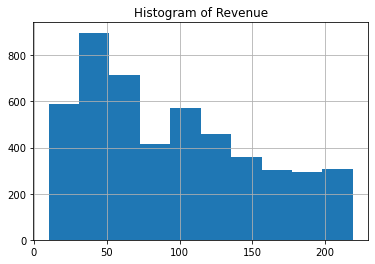

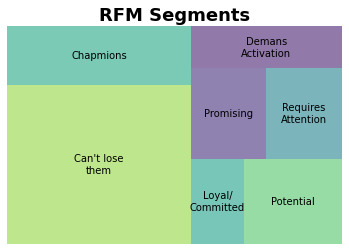

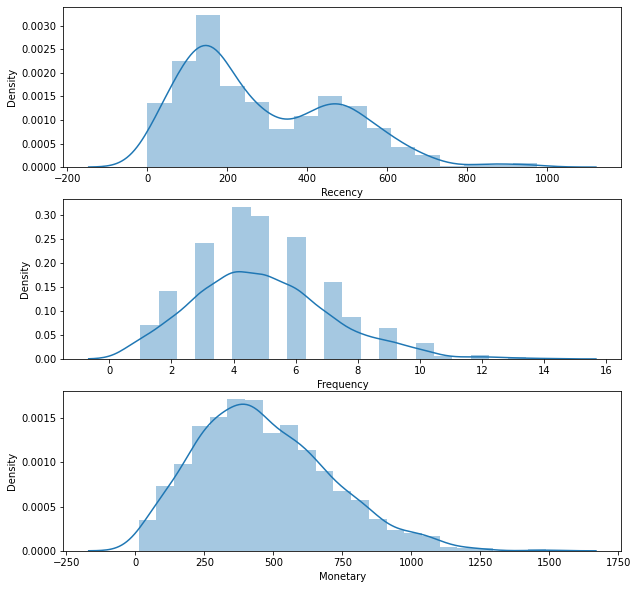

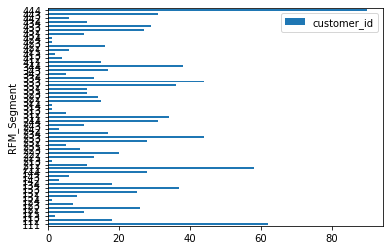

Best: Mr. Cletus Corwin, Giuseppe Tremblay, Epifanio Kozey
Worst: Jayvion Cummings, Sherlyn Gutmann, Lorean Stokes DVM


In [100]:
rfm.problemsolver()

In [80]:
rfm.table()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Score,RFM_Segment,Segment_Name
654,Mr. Cletus Corwin,557,2,81,4,4,4,12,444,Can't Loose Them
379,Giuseppe Tremblay,576,3,162,4,4,4,12,444,Can't Loose Them
330,Epifanio Kozey,492,1,43,4,4,4,12,444,Can't Loose Them
824,Pierre Stoltenberg,617,2,82,4,4,4,12,444,Can't Loose Them
333,Errol Bogisich,683,1,81,4,4,4,12,444,Can't Loose Them
...,...,...,...,...,...,...,...,...,...,...
196,Dominik Anderson,19,10,1249,1,1,1,3,111,Demands Activation
198,Donaciano Corwin,11,8,892,1,1,1,3,111,Demands Activation
439,Jayvion Cummings,52,9,1090,1,1,1,3,111,Demands Activation
893,Sherlyn Gutmann,18,9,726,1,1,1,3,111,Demands Activation


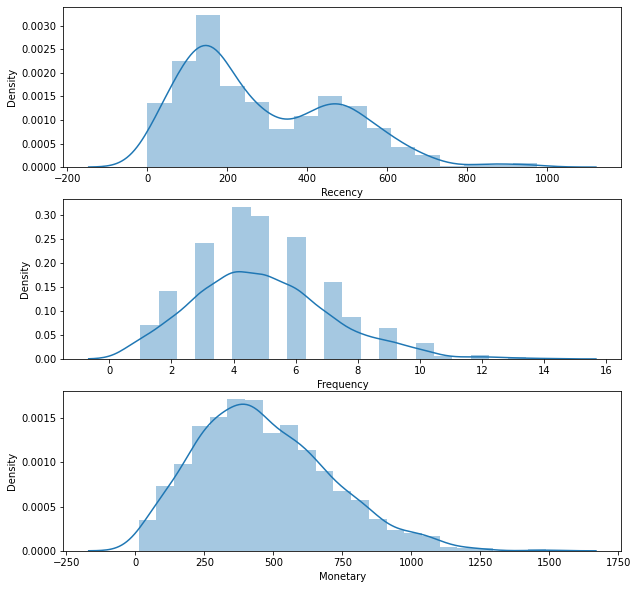

In [81]:
rfm.plot_traits(n_quantiles = 6)

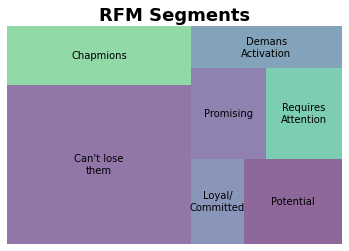

In [82]:
rfm.plot_segments()

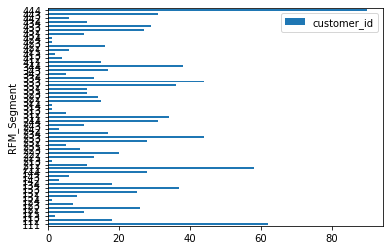

In [83]:
rfm.plot_segments_lines()